In [1]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 631.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 32.0 MB/s eta 0:00:00


# Image-to-Image

Applications:
* image enhancement (super resolution, low light enhancement, deraining, etc)
* image inpainting
* ....

We will use `pipeline` to initialize a `Swin2SR` MODEL.

In [2]:
from transformers import pipeline
import torch
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
pipe = pipeline(
    task='image-to-image',
    model='caidas/swin2SR-lightweight-x2-64',
    device=device
)

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.08M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


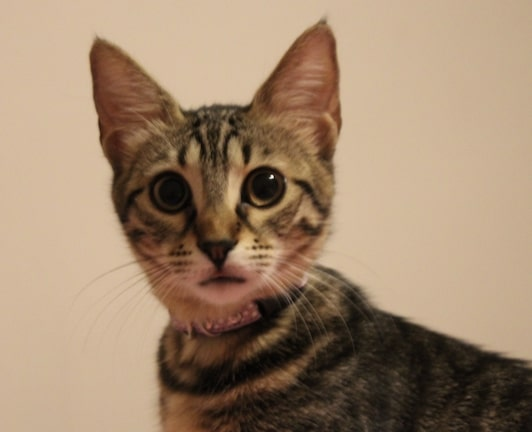

In [3]:
# load an image
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [4]:
image.size

(532, 432)

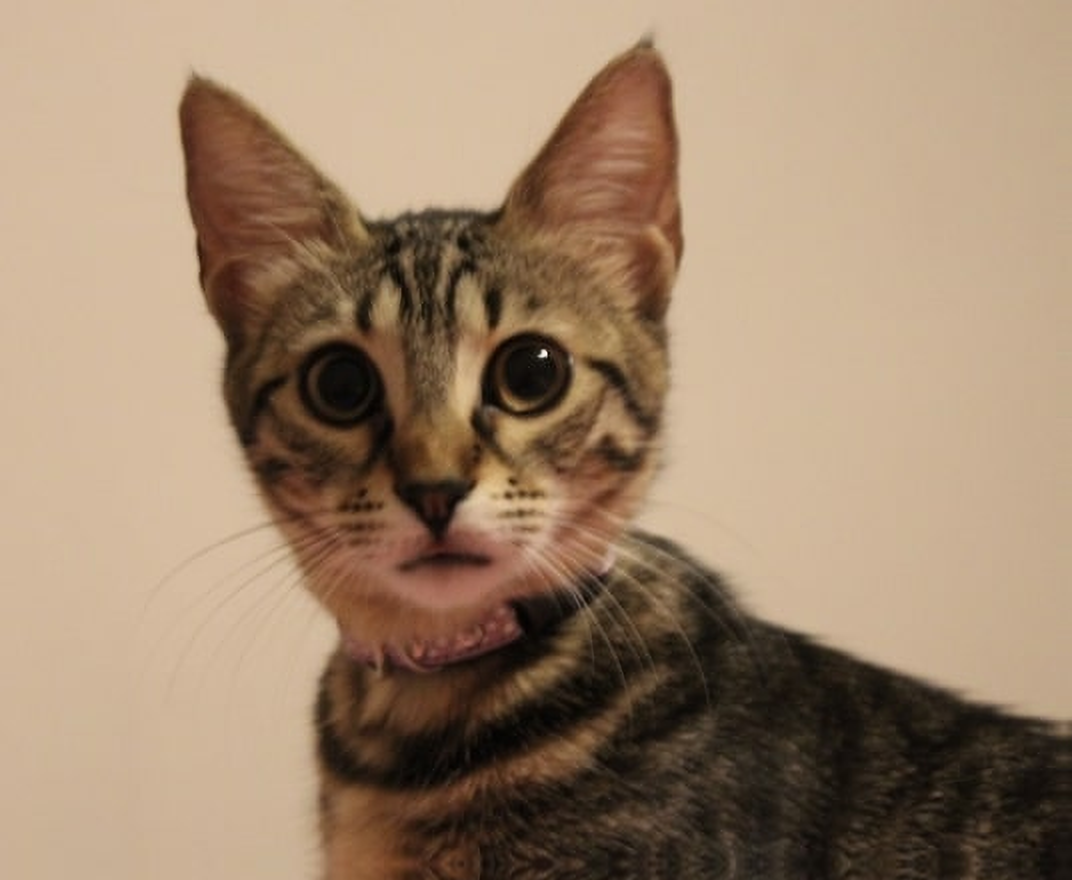

In [6]:
# inference for upscaling
upscaled = pipe(image)
upscaled

In [7]:
upscaled.size

(1072, 880)

In [8]:
# Manually load models
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

model = Swin2SRForImageSuperResolution.from_pretrained('caidas/swin2SR-lightweight-x2-64').to(device)
processor = Swin2SRImageProcessor.from_pretrained('caidas/swin2SR-lightweight-x2-64')

In [9]:
# preprocessing
pixel_values = processor(
    image,
    return_tensors='pt'
).pixel_values
print(pixel_values.shape)
pixel_values = pixel_values.to(device)

torch.Size([1, 3, 440, 536])


In [10]:
import torch

with torch.no_grad():
    outputs = model(pixel_values)
outputs

ImageSuperResolutionOutput(loss=None, reconstruction=tensor([[[[0.8269, 0.8269, 0.8275,  ..., 0.7464, 0.7446, 0.7453],
          [0.8287, 0.8277, 0.8283,  ..., 0.7451, 0.7448, 0.7457],
          [0.8280, 0.8272, 0.8269,  ..., 0.7447, 0.7447, 0.7453],
          ...,
          [0.7923, 0.7924, 0.7918,  ..., 0.1048, 0.1046, 0.1060],
          [0.7927, 0.7926, 0.7931,  ..., 0.1028, 0.1038, 0.1062],
          [0.7937, 0.7917, 0.7929,  ..., 0.1019, 0.1057, 0.1082]],

         [[0.7256, 0.7246, 0.7256,  ..., 0.6521, 0.6512, 0.6523],
          [0.7261, 0.7253, 0.7258,  ..., 0.6513, 0.6506, 0.6514],
          [0.7260, 0.7253, 0.7252,  ..., 0.6515, 0.6505, 0.6505],
          ...,
          [0.6903, 0.6906, 0.6903,  ..., 0.0856, 0.0847, 0.0860],
          [0.6907, 0.6910, 0.6914,  ..., 0.0834, 0.0838, 0.0861],
          [0.6906, 0.6896, 0.6910,  ..., 0.0820, 0.0851, 0.0877]],

         [[0.6285, 0.6277, 0.6287,  ..., 0.5498, 0.5501, 0.5503],
          [0.6278, 0.6277, 0.6290,  ..., 0.5491, 0.5468

We need to get the `reconstruction` and post-process it for visualization

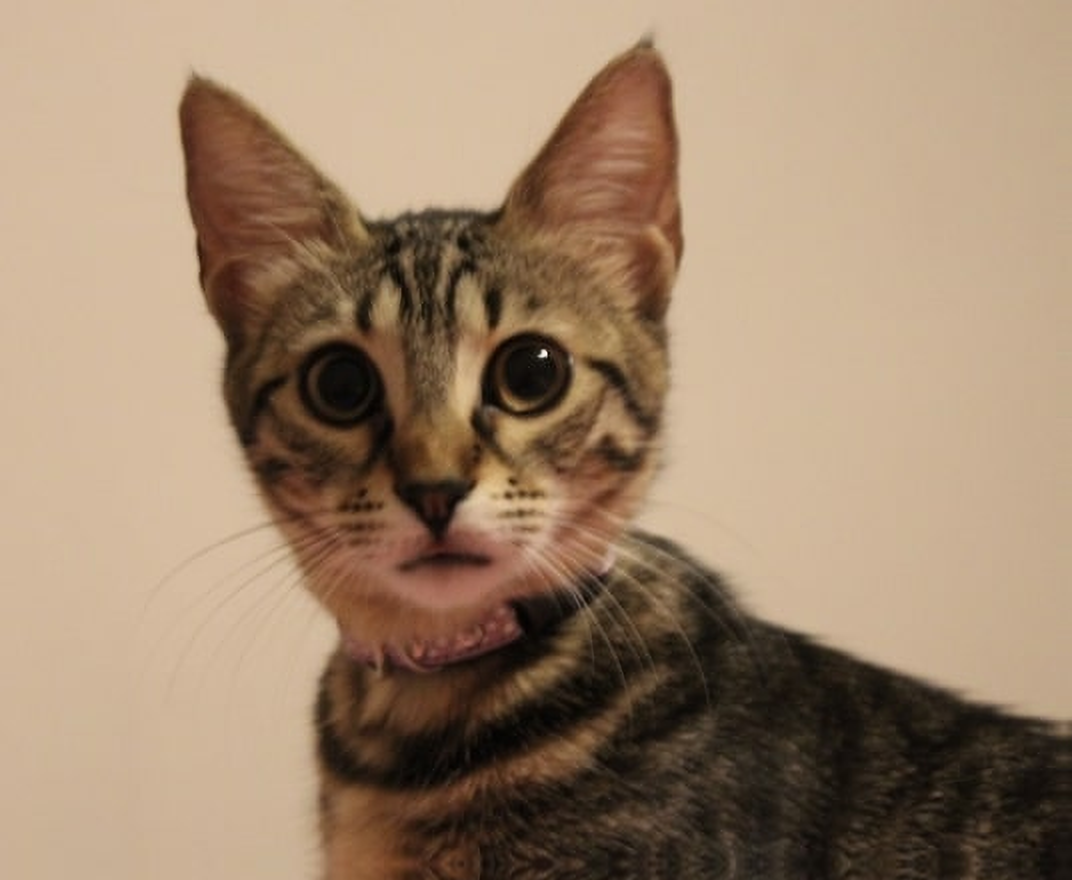

In [11]:
import numpy as np

output = outputs.reconstruction.data.squeeze().cpu().clamp_(0, 1).numpy()
# rearrange the axes
output = np.moveaxis(output, source=0, destination=-1)
# bring values back to pixel value range
output = (output * 255).round().astype(np.uint8)
Image.fromarray(output)